In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

import math

from matplotlib import cm

import matplotlib.lines as mlines

%matplotlib inline

### AIR POLLUTION MONITORING DATA FROM EDF

In [2]:
df = pd.read_csv('EDF_Data.csv', header = 1)
df['TimePeriod'] = 'Jun2015-May2016'
df.tail()

,Longitude,Latitude,NO Value,NO2 Value,BC Value,TimePeriod
21483,-122.034943,37.560076,129.999995,44.778220,3.923761,Jun2015-May2016
21484,-122.034724,37.560164,60.799998,39.027545,1.408693,Jun2015-May2016
21485,-122.034681,37.559830,34.622951,28.816797,2.659885,Jun2015-May2016
21486,-122.034504,37.559958,74.764705,35.735434,1.776353,Jun2015-May2016
21487,-122.034503,37.559957,78.754782,41.062757,2.014664,Jun2015-May2016


In [3]:
df.shape

(21488, 6)

In [4]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

### Split the dataset into BC and NO2 since we are interested only in those two pollutants

In [5]:
BC_df = df[['Longitude', 'Latitude', 'BC Value', 'TimePeriod']]

In [6]:
NO2_df = df[['Longitude', 'Latitude', 'NO2 Value', 'TimePeriod']]

### METEROLOGICAL DATASET

In [35]:
df_met = pd.read_csv("MetStations_CA.csv")
df_met.head()

,STATION_ID,STATION,BEGIN_DATE,END_DATE,STATE,COUNTRY,LATITUDE,LONGITUDE,ELEVATION_(M)
0,WBAN:23239,"ALAMEDA NAS, CA US",1945-02-28,1997-01-31,California,United States,37.78333,-122.31667,9.1
1,WBAN:94299,"ALTURAS MUNICIPAL AIRPORT, CA US",2004-12-31,2020-02-23,California,United States,41.49139,-120.56444,1333.5
2,WBAN:24283,"ARCATA EUREKA AIRPORT, CA US",1949-11-30,2020-02-23,California,United States,40.97806,-124.10861,61.0
3,WBAN:23224,"AUBURN MUNICIPAL AIRPORT, CA US",2004-12-31,2020-02-23,California,United States,38.95472,-121.08194,466.6
4,WBAN:23191,"AVALON CATALINA AIRPORT, CA US",1943-06-11,2020-02-23,California,United States,33.40500,-118.41583,488.3


In [36]:
crs = {'init': 'epsg:4326'}
geometry_met = [Point(xy) for xy in zip(df_met['LONGITUDE'], df_met['LATITUDE'])]
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)
geo_df_met = gpd.GeoDataFrame(df_met, crs = crs, geometry = geometry_met)

### FACILITY LEVEL DATA

In [7]:
# Read data for Oakland and drop duplicate facility ids
oak_facility = pd.read_csv('Data/oakland_facility_2017.csv', header = 0)
# Display all columns in the dataframe
oak_facility.columns

Index(['Unnamed: 0', 'county', 'eis facility id', 'agency facility id',
       'tri facility id', 'company name', 'site name', 'facility source type',
       'site latitude', 'site longitude', 'address', 'city', 'zip code',
       'pollutant code', 'pollutant type(s)', 'total emissions',
       'emissions uom', 'data set'],
      dtype='object')

In [8]:
# Drop columns that are not needed 
oak_facility.drop(columns = ['agency facility id', 'tri facility id','pollutant type(s)', 'data set', 'address',
                             'site name','facility source type','Unnamed: 0', 'county'], inplace=True)

In [9]:
# Rename site latitude and site longitude column to just latitude and logitude
oak_facility.rename(columns={"site latitude": "latitude", "site longitude": "longitude"}, inplace=True)

In [10]:
# Display all columns in the dataframe
oak_facility.columns

Index(['eis facility id', 'company name', 'latitude', 'longitude', 'city',
       'zip code', 'pollutant code', 'total emissions', 'emissions uom'],
      dtype='object')

In [11]:
# Filter the dataframe further for sources/facilities only in Oakland and neighbouring cities like San Leandro, Piedmont, Alameda and Berkeley
oak_facility = oak_facility[(oak_facility['city'] == 'OAKLAND') | (oak_facility['city'] == 'SAN LEANDRO') | (oak_facility['city'] == 'BERKELEY')|
                           (oak_facility['city'] == 'ALAMEDA') | (oak_facility['city'] == 'PIEDMONT')]

In [12]:
oak_facility.head()

,eis facility id,company name,latitude,longitude,city,zip code,pollutant code,total emissions,emissions uom
3,126911,PACIFIC BELL,37.76685,-122.24972,ALAMEDA,94501,NOX,0.054659,TON
4,126911,PACIFIC BELL,37.76685,-122.24972,ALAMEDA,94501,PM10-PRI,0.000749,TON
5,126911,PACIFIC BELL,37.76685,-122.24972,ALAMEDA,94501,PM25-PRI,0.000731,TON
9,127111,PACIFIC BELL,37.86771,-122.26784,BERKELEY,94704,NOX,0.162383,TON
10,127111,PACIFIC BELL,37.86771,-122.26784,BERKELEY,94704,PM10-PRI,0.002226,TON


In [13]:
## Creating a separate dataframe for NOx
Facility_NO2 = oak_facility[oak_facility['pollutant code'] == 'NOX']

In [14]:
Facility_NO2.shape

(328, 9)

In [15]:
## Creating a separate dataframe for PM/Black carbon
Oak_PM10_25 = oak_facility[oak_facility['pollutant code'] != 'NOX']

In [16]:
PM10_pri = Oak_PM10_25[Oak_PM10_25['pollutant code']=='PM10-PRI']

In [17]:
## Drop PM10-PRI rows in Oak_PM dataframe
Oak_PM25  = Oak_PM10_25[Oak_PM10_25['pollutant code'] == 'PM25-PRI']

In [18]:
Facility_PM = pd.merge(Oak_PM25, PM10_pri, left_on ='eis facility id', right_on ='eis facility id', how='inner')


In [19]:
Facility_PM

,eis facility id,company name_x,latitude_x,longitude_x,city_x,zip code_x,pollutant code_x,total emissions_x,emissions uom_x,company name_y,latitude_y,longitude_y,city_y,zip code_y,pollutant code_y,total emissions_y,emissions uom_y
0,126911,PACIFIC BELL,37.766850,-122.249720,ALAMEDA,94501,PM25-PRI,0.000731,TON,PACIFIC BELL,37.766850,-122.249720,ALAMEDA,94501,PM10-PRI,0.000749,TON
1,127111,PACIFIC BELL,37.867710,-122.267840,BERKELEY,94704,PM25-PRI,0.002173,TON,PACIFIC BELL,37.867710,-122.267840,BERKELEY,94704,PM10-PRI,0.002226,TON
2,127511,PACIFIC BELL,37.806030,-122.269460,OAKLAND,94612,PM25-PRI,0.008291,TON,PACIFIC BELL,37.806030,-122.269460,OAKLAND,94612,PM10-PRI,0.008494,TON
3,127611,PACIFIC BELL,37.784220,-122.222410,OAKLAND,94601,PM25-PRI,0.000706,TON,PACIFIC BELL,37.784220,-122.222410,OAKLAND,94601,PM10-PRI,0.000724,TON
4,127711,PACIFIC BELL,37.833360,-122.263070,OAKLAND,94609,PM25-PRI,0.001554,TON,PACIFIC BELL,37.833360,-122.263070,OAKLAND,94609,PM10-PRI,0.001592,TON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,18778911,NaN,37.712960,-122.188680,SAN LEANDRO,94577,PM25-PRI,22.124544,TON,NaN,37.712960,-122.188680,SAN LEANDRO,94577,PM10-PRI,22.971518,TON
358,18779811,NaN,37.707820,-122.185500,SAN LEANDRO,94577,PM25-PRI,0.000015,TON,NaN,37.707820,-122.185500,SAN LEANDRO,94577,PM10-PRI,0.000015,TON
359,18781211,NaN,37.812106,-122.186447,OAKLAND,94621,PM25-PRI,0.000061,TON,NaN,37.812106,-122.186447,OAKLAND,94621,PM10-PRI,0.000061,TON
360,18782611,NaN,37.759959,-122.207782,OAKLAND,94621,PM25-PRI,0.992654,TON,NaN,37.759959,-122.207782,OAKLAND,94621,PM10-PRI,1.030213,TON


In [20]:
Facility_PM.drop(columns = ['zip code_x','pollutant code_x', 'emissions uom_x','company name_y','latitude_y','longitude_y',
                      'city_y','zip code_y','pollutant code_y','emissions uom_x'], inplace=True)

In [21]:
# Rename columns to meaningful names
Facility_PM.rename(columns={"latitude_x": "latitude", "longitude_x": "longitude", "city_x": "city", 
                       "total emissions_x" : "PM25", "total emissions_y": "PM10", "emissions uom_y": "units"}, inplace=True)

In [22]:
Facility_PM.head()

,eis facility id,company name_x,latitude,longitude,city,PM25,PM10,units
0,126911,PACIFIC BELL,37.76685,-122.24972,ALAMEDA,0.000731,0.000749,TON
1,127111,PACIFIC BELL,37.86771,-122.26784,BERKELEY,0.002173,0.002226,TON
2,127511,PACIFIC BELL,37.80603,-122.26946,OAKLAND,0.008291,0.008494,TON
3,127611,PACIFIC BELL,37.78422,-122.22241,OAKLAND,0.000706,0.000724,TON
4,127711,PACIFIC BELL,37.83336,-122.26307,OAKLAND,0.001554,0.001592,TON


In [23]:
Facility_PM.shape

(362, 8)

In [24]:
Facility_NO2['city'].unique()

array(['ALAMEDA', 'BERKELEY', 'OAKLAND', 'SAN LEANDRO', 'PIEDMONT'],
      dtype=object)

## TRAFFIC DATA

In [25]:
### Load Annual Average Daily Traffic (AADT) file from Caltrans
traffic = pd.read_csv('Data/Traffic_Oakland_AADT.csv', header = 0)

In [26]:
# Drop columns that are unneccessary and choose only Ahead_AADT, along with N/E latitude and longitude
traffic.drop(columns = ['OBJECTID','District','Route','County', 'Postmile', 
                        'Back_pk_h', 'Back_pk_m', 'Ahead_pk_h', 'Ahead_pk_m','Back_AADT','Lat_S_or_W', 'Lon_S_or_W'], inplace=True)

In [27]:
traffic.rename(columns={"Ahead_AADT":"AADT", "Lat_N_or_E":"Latitude", "Lon_N_or_E":"Longitude", "Descriptn":"Description"}, inplace=True)

In [28]:
traffic.head()

,Description,AADT,Latitude,Longitude
0,"ALAMEDA, BROADWAY/ ENCINAL AVENUE",8700,37.760576,-122.240708
1,"ALAMEDA, CENTRAL AVENUE/ SHERMAN STREET",9500,37.770910,-122.263477
2,JCT. RTE. 260 NORTH,0,37.771459,-122.276894
3,"OAKLAND, JCT. RTE. 880",22900,37.769397,-122.221166
4,"OAKLAND, EAST 12TH STREET",16400,37.772068,-122.217378


In [29]:
# Taking a closer look at the traffic data, there are some intersections where the AADT is zero, or the latitude and longitude are zero. We want to drop these rows
traffic = traffic[(traffic['Longitude']<-1) & (traffic['AADT']>1)]

In [30]:
traffic.shape

(71, 4)

## Converting facility and traffic dataframe into a geopandas dataframe for plotting

In [37]:
# Create a list of x and y coordinates to convert to a geodataframe using geopandas
geometry_facility = [Point(xy) for xy in zip(oak_facility['longitude'], oak_facility['latitude'])]

In [38]:
# Create a geopandas dataframe with the coordinate reference system as epsg4326
geo_df_facility = gpd.GeoDataFrame(oak_facility, crs = crs, geometry = geometry_facility)

In [39]:
# Create a geopandas dataframe with traffic data
geometry_traffic = [Point(xy) for xy in zip(traffic['Longitude'], traffic['Latitude'])]
geo_df_traffic = gpd.GeoDataFrame(traffic, crs = crs, geometry = geometry_traffic)

In [40]:
# Create a list of x and y coordinates for the PM facility data in Oakland using geopandas
geometry_facility_PM = [Point(xy) for xy in zip(Facility_PM['longitude'], Facility_PM['latitude'])]
geo_df_facility_PM = gpd.GeoDataFrame(Facility_PM, crs = crs, geometry = geometry_facility_PM)

In [41]:
# Create a list of x and y coordinates for the Black Carbon concentration data using geopandas
geometry_df_BC = [Point(xy) for xy in zip(BC_df['Longitude'], BC_df['Latitude'])]
geo_df_BC = gpd.GeoDataFrame(BC_df, crs = crs, geometry = geometry_df_BC)

## Pu(lo)tting all together  

### Plotting Oakland Basemap (shapefile)

In [42]:
oakl = gpd.read_file('Oakland-shapefile/OaklandZoning_Eff20181211_Ord13513.shp')

In [43]:
oakl.head()

,FID,OBJECTID,AREA,PERIMETER,BASEZONE,OVERLAY,ZNLABEL,ORDINANCE,LASTUPDATE,GLOBALID,SHAPE_AREA,SHAPE_LEN,Shape__Are,Shape__Len,geometry
0,1,2564,463428.469786,3325.153525,RM-3,None,RM-3,None,20180327,{9D6F625B-B567-4B94-86EF-A5BCB06DC547},463428.469786,3325.153525,69024.062500,1283.361119,"POLYGON ((-122.19994 37.76732, -122.20039 37.7..."
1,2,1813,558079.266415,6474.259271,OS (RCA),None,OS (RCA),13276,20180327,{A2EC4B15-CBDD-499C-8660-B70F90566564},558079.266419,6474.259271,83181.558594,2501.498512,"POLYGON ((-122.25921 37.79733, -122.25922 37.7..."
2,3,2139,43129.700341,1086.970123,CC-2,/S-7,CC-2/S-7,None,20180327,{BF636AD7-DD80-47FA-B2D0-97614B55EC75},43129.700340,1086.970123,6430.570312,419.525144,"POLYGON ((-122.29849 37.80666, -122.29850 37.8..."
3,4,2565,104035.317933,1328.336204,RM-3,None,RM-3,None,20180327,{A6197605-035A-4F64-AD67-084FB60661D7},104035.317934,1328.336204,15495.957031,512.707291,"POLYGON ((-122.19655 37.76915, -122.19627 37.7..."
4,5,1814,553731.995607,3549.473783,CC-1,None,CC-1,None,20180327,{30FA7150-F5A0-489F-8415-2018DBB78376},553731.995610,3549.473783,82541.093750,1370.391443,"POLYGON ((-122.18167 37.79756, -122.18167 37.7..."


In [44]:
oakl.crs

{'init': 'epsg:4326'}

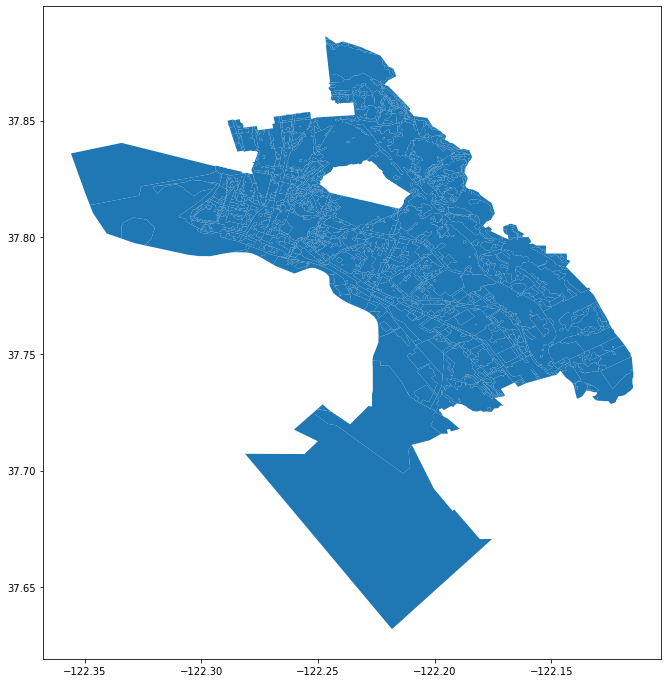

In [45]:
fig, ax = plt.subplots(figsize = (12,12))
oakl.plot(ax = ax)

#### Plotting black carbon data and location of all near-by sources

In [46]:
### legend handles for facilities


maroon_x = mlines.Line2D([], [], color='maroon', marker='x', linestyle='None',
                          markersize=6, label='Alameda')
orange_x = mlines.Line2D([], [], color='darkorange', marker='x', linestyle='None',
                          markersize=6, label='Berkeley')
yellow_x = mlines.Line2D([], [], color='lemonchiffon', marker='x', linestyle='None',
                          markersize=6, label='Oakland')
green_x = mlines.Line2D([], [], color='limegreen', marker='x', linestyle='None',
                          markersize=6, label='Piedmont')
blue_x = mlines.Line2D([], [], color='slateblue', marker='x', linestyle='None',
                          markersize=6, label='San Leandro')

fuchsia_o = mlines.Line2D([], [], color='fuchsia', marker='o', linestyle='None',
                          markersize=6, label='Traffic ')


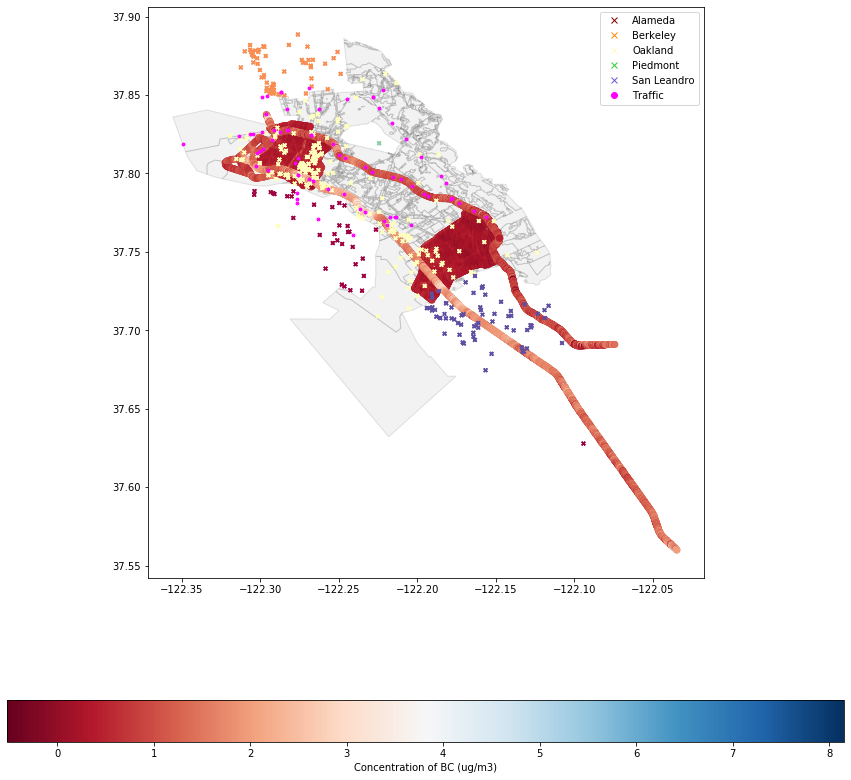

In [47]:

fig, ax = plt.subplots(figsize = (15,15)) #This creates a figure axis
vmin = geo_df['BC Value'].min()           #Minimum value of black carbon concentration for legend
vmax = geo_df['BC Value'].max()           #Maximum value of black carbon concentration for legend
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile


geo_df.plot(ax = ax, column = 'BC Value', legend=False, legend_kwds={'label': "Concentration of NO",
                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.xlim([-122.32,-122.25])
#plt.ylim([37.76,37.9])
#plt.ylim([37.8,37.82])


#cax = fig.add_axes([1, 0.05, 0.03, 0.8])
sm = cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
#sm._A = []
#cbr = fig.colorbar(sm)
#cbr.ax.tick_params(labelsize=20) 
ax.get_figure().colorbar(sm, ax=ax, orientation='horizontal', label = 'Concentration of BC (ug/m3)')
geo_df_facility.plot(ax=ax, cmap='Spectral', column = 'city', legend = True, marker='x', markersize = 12)
geo_df_traffic.plot(ax=ax, legend=True, marker='o', markersize = 8, color='fuchsia')
plt.legend(handles=[maroon_x, orange_x, yellow_x, green_x, blue_x, fuchsia_o])
#geo_df.plot(ax = ax, column = 'BC Value', legend=False, legend_kwds={'label': "Concentration of NO",
#                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.tight_layout()
#plt.savefig(os.path.join('out','fig.png'),format = 'png',bbox_inches='tight')
plt.show()

#### Plotting NOx data and location of all near-by sources

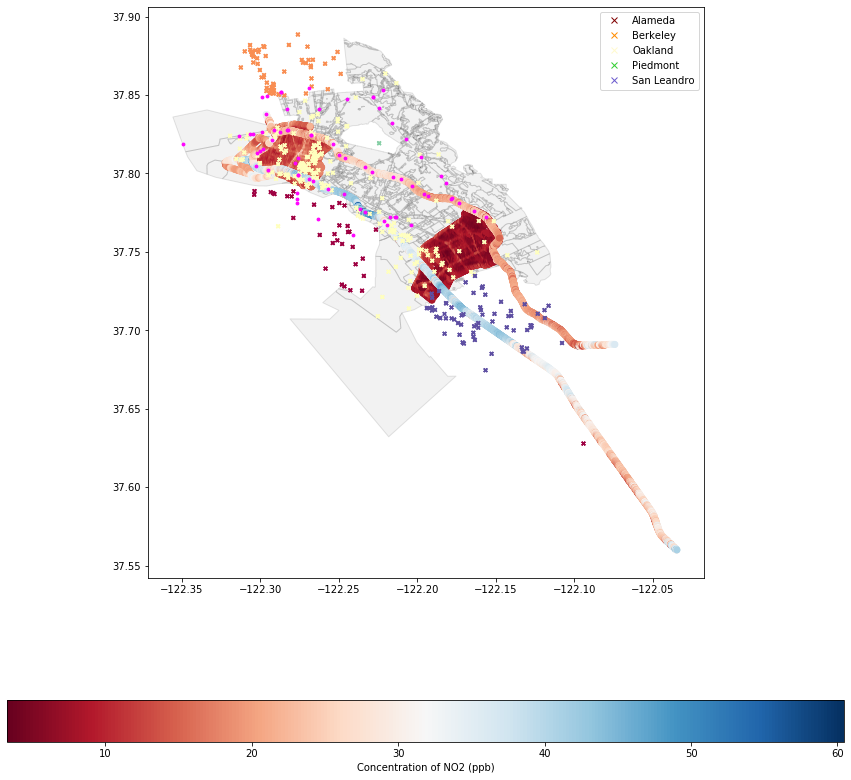

In [48]:
fig, ax = plt.subplots(figsize = (15,15)) #This creates a figure axis
vmin = geo_df['NO2 Value'].min()           #Minimum value of black carbon concentration for legend
vmax = geo_df['NO2 Value'].max()           #Maximum value of black carbon concentration for legend
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile


geo_df.plot(ax = ax, column = 'NO2 Value', legend=False, legend_kwds={'label': "Concentration of NO",
                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.xlim([-122.25,-122.15])
#plt.ylim([37.7,37.9])


#cax = fig.add_axes([1, 0.05, 0.03, 0.8])
sm = cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
#sm._A = []
#cbr = fig.colorbar(sm)
#cbr.ax.tick_params(labelsize=20) 
ax.get_figure().colorbar(sm, ax=ax, orientation='horizontal', label = 'Concentration of NO2 (ppb)')
geo_df_facility.plot(ax=ax, cmap='Spectral', column = 'city', legend = True, marker='x', markersize = 12)
geo_df_traffic.plot(ax=ax, legend=True, marker='o', markersize = 8, color='fuchsia')
plt.legend(handles=[maroon_x, orange_x, yellow_x, green_x, blue_x])
#geo_df.plot(ax = ax, column = 'BC Value', legend=False, legend_kwds={'label': "Concentration of NO",
#                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.tight_layout()
#plt.savefig(os.path.join('out','fig.png'),format = 'png',bbox_inches='tight')
plt.show()

## Creating input dataframe - Method 1: 
### Here I find the nearest facility or traffic intersection to each point in the EDF data. The corresponding BC/NOx values or AADT values will be included as an addiitonal column. 

### Find Closest Facility and Traffic Intersection to each point in the EDF data

#### Unary Union of the geo_df geometry - Closest Facility

pts = geo_df_facility_PM.geometry.unary_union
def near(point, pts=pts):
     # find the nearest point and return the corresponding Station name
     nearest = geo_df_facility_PM.geometry == nearest_points(point, pts)[1]
     return geo_df_facility_PM[nearest]['eis facility id'].to_numpy()[0]
geo_df_BC['Nearest_Facility'] = geo_df_BC.apply(lambda row: near(row.geometry), axis=1)

#### Unary Union of the geo_df geometry - Closest Traffic Intersection

pts = geo_df_traffic.geometry.unary_union
def near(point, pts=pts):
     # find the nearest point and return the corresponding Station name
     nearest = geo_df_traffic.geometry == nearest_points(point, pts)[1]
     return geo_df_traffic[nearest]['Description'].to_numpy()[0]
geo_df_BC['Nearest_Traffic'] = geo_df_BC.apply(lambda row: near(row.geometry), axis=1)

#### Merge df_BC with Oak_PM on Facility ID
df_BC_merge = pd.merge(left=df_BC, right=Oak_PM, left_on='Nearest_Facility', right_on='eis facility id')

#### Merge above dataframe with traffic
df_BC_merge_traffic = pd.merge(left=df_BC_merge, right=traffic, left_on='Nearest_Traffic', right_on='Description')

df_BC_merge_traffic.head()

df_BC_merge_traffic.rename(columns={'Latitude_x':'Latitude_Conc','Longitude_x':'Longitude_Conc','latitude':'Latitude_Fac','longitude':'Longitude_Fac','Latitude_y':'Latitude_Traf','Longitude_y':'Longitude_Traf'}, inplace=True)

df_BC_merge_traffic.head()

df_BC_merge_traffic.columns

#### Create an empty list call dist which stores all the distances between each point (facility and traffic)
dist_fac = []
dist_traf = []

### Defining a function to calculate the distance between two GPS coordinates (latitude and longitude)
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

for row in df_BC_merge_traffic.iterrows():
    dist_fac.append(distance((row[1]['Latitude_Conc'], row[1]['Longitude_Conc']), (row[1]['Latitude_Fac'], row[1]['Longitude_Fac'])))
    dist_traf.append(distance((row[1]['Latitude_Conc'], row[1]['Longitude_Conc']), (row[1]['Latitude_Traf'], row[1]['Longitude_Traf'])))

df_BC_merge_traffic['Dist_Facility_mi'] = np.array(dist_fac)*0.621
df_BC_merge_traffic['Dist_Traffic_mi'] = np.array(dist_traf)*0.621

#### Drop columns from df_BC_merge that are not needed anymore
df_BC_merge_traffic.drop(columns = ['eis facility id','company name_x','city','units', 'Description', 'Nearest_Traffic'], inplace=True)

#### Rename columns
df_BC_merge_traffic.rename(columns = {'geometry_x':'Conc_geo', 'geometry_y':'Fac_geo','geometry':'Traf_geo'}, inplace=True)

df_BC_merge_traffic.head()

## Creating input dataframe - Method 2: 
#### In this approach, distance to each individual industry from the point of measurement, and the corresponding PM10 and PM2.5 emissions are indivudial features. Looking at the map further, industrial sources in Oakland, Piedmont and Alameda are closest to the measurement points. We filter out all other industrial sources. 

### Combining Air Pollution Monitoring Data and Facility level data

In [49]:
Facility_PM_All = Facility_PM.copy()

In [50]:
Facility_PM = Facility_PM[(Facility_PM['city'] == 'OAKLAND') | (Facility_PM['city'] == 'SAN LEANDRO') | (Facility_PM['city'] == 'ALAMEDA')]

In [51]:
Facility_PM.shape

(302, 9)

In [52]:
Facility_PM.describe()

,eis facility id,latitude,longitude,PM25,PM10
count,3.020000e+02,302.000000,302.000000,3.020000e+02,3.020000e+02
mean,1.182273e+07,37.769337,-122.229118,4.477258e-01,6.151556e-01
std,6.302605e+06,0.044275,0.051563,2.294472e+00,3.063150e+00
min,1.269110e+05,37.627747,-122.319375,4.000000e-09,5.000000e-09
25%,1.046726e+07,37.729447,-122.270680,1.181368e-04,1.210365e-04
50%,1.383541e+07,37.775865,-122.243729,6.589345e-04,6.876330e-04
75%,1.724534e+07,37.805574,-122.187804,1.480650e-02,2.165194e-02
max,1.878701e+07,37.863670,-122.094062,2.212454e+01,2.626146e+01


In [53]:
Facility_PM.head()

,eis facility id,company name_x,latitude,longitude,city,PM25,PM10,units,geometry
0,126911,PACIFIC BELL,37.76685,-122.24972,ALAMEDA,0.000731,0.000749,TON,POINT (-122.24972 37.76685)
2,127511,PACIFIC BELL,37.80603,-122.26946,OAKLAND,0.008291,0.008494,TON,POINT (-122.26946 37.80603)
3,127611,PACIFIC BELL,37.78422,-122.22241,OAKLAND,0.000706,0.000724,TON,POINT (-122.22241 37.78422)
4,127711,PACIFIC BELL,37.83336,-122.26307,OAKLAND,0.001554,0.001592,TON,POINT (-122.26307 37.83336)
5,127811,PACIFIC BELL,37.81186,-122.19840,OAKLAND,0.000336,0.000344,TON,POINT (-122.19840 37.81186)


#### Looking at the basic statistics of the emissions, we can filter out the rows below the 2nd quartile as the emissions are very low.  Typically, sources with more than 1 ton of annual emissions are considered as major sources, sources below this are typically considered a minor source. 

In [54]:
lower, upper = Facility_PM.PM10.quantile([0.5,1])
Facility_PM = Facility_PM.query('{low}<PM10<{high}'.format(low=lower,high=upper))

In [55]:
Facility_PM.head()

,eis facility id,company name_x,latitude,longitude,city,PM25,PM10,units,geometry
0,126911,PACIFIC BELL,37.76685,-122.24972,ALAMEDA,0.000731,0.000749,TON,POINT (-122.24972 37.76685)
2,127511,PACIFIC BELL,37.80603,-122.26946,OAKLAND,0.008291,0.008494,TON,POINT (-122.26946 37.80603)
3,127611,PACIFIC BELL,37.78422,-122.22241,OAKLAND,0.000706,0.000724,TON,POINT (-122.22241 37.78422)
4,127711,PACIFIC BELL,37.83336,-122.26307,OAKLAND,0.001554,0.001592,TON,POINT (-122.26307 37.83336)
6,128211,PACIFIC BELL,37.70014,-122.12997,SAN LEANDRO,0.000863,0.000884,TON,POINT (-122.12997 37.70014)


#### Create a dataframe where each column is one of the industrial facilities, with columns as latitude, longitude, PM2.5 PM10 emissions value and geometry. 

In [56]:
Oak_PM_lat = Facility_PM[['eis facility id', 'latitude']]
Oak_PM_long = Facility_PM[['eis facility id', 'longitude']]
Oak_PM_PM25 = Facility_PM[['eis facility id', 'PM25']]
Oak_PM_PM10 = Facility_PM[['eis facility id', 'PM10']]
Oak_PM_geo = Facility_PM[['eis facility id', 'geometry']]


In [57]:
# Transpose all the dataframes
Oak_PM_lat = Oak_PM_lat.T
Oak_PM_long = Oak_PM_long.T
Oak_PM_PM25 = Oak_PM_PM25.T
Oak_PM_PM10 = Oak_PM_PM10.T
Oak_PM_geo = Oak_PM_geo.T

In [58]:
## Make the header as the first row in each transposed dataframe
Oak_PM_lat = Oak_PM_lat.rename(columns=Oak_PM_lat.iloc[0].astype(int)).drop(Oak_PM_lat.index[0])
Oak_PM_long = Oak_PM_long.rename(columns=Oak_PM_long.iloc[0].astype(int)).drop(Oak_PM_long.index[0])
Oak_PM_PM25 = Oak_PM_PM25.rename(columns=Oak_PM_PM25.iloc[0].astype(int)).drop(Oak_PM_PM25.index[0])
Oak_PM_PM10 = Oak_PM_PM10.rename(columns=Oak_PM_PM10.iloc[0].astype(int)).drop(Oak_PM_PM10.index[0])
Oak_PM_geo = Oak_PM_geo.rename(columns=Oak_PM_geo.iloc[0].astype(int)).drop(Oak_PM_geo.index[0])

In [59]:
## Add suffix to column header based on the dataframe type
Oak_PM_lat.columns = [str(col) + '_latitude' for col in Oak_PM_lat.columns]
Oak_PM_long.columns = [str(col) + '_longitude' for col in Oak_PM_long.columns]
Oak_PM_PM25.columns = [str(col) + '_PM25' for col in Oak_PM_PM25.columns]
Oak_PM_PM10.columns = [str(col) + '_PM10' for col in Oak_PM_PM10.columns]
Oak_PM_geo.columns = [str(col) + '_geo' for col in Oak_PM_geo.columns]

In [60]:
## Remove index for each dataframe
Oak_PM_lat.reset_index(drop=True, inplace=True)
Oak_PM_long.reset_index(drop=True, inplace=True)
Oak_PM_PM25.reset_index(drop=True, inplace=True)
Oak_PM_PM10.reset_index(drop=True, inplace=True)
Oak_PM_geo.reset_index(drop=True, inplace=True)

In [61]:
Oak_PM_combined = Oak_PM_lat.join(Oak_PM_long).join(Oak_PM_PM25).join(Oak_PM_PM10).join(Oak_PM_geo)


In [62]:
Oak_PM_combined

,126911_latitude,127511_latitude,127611_latitude,127711_latitude,128211_latitude,136511_latitude,137211_latitude,140211_latitude,141411_latitude,168411_latitude,...,18542011_geo,18697111_geo,18697211_geo,18697911_geo,18698311_geo,18705211_geo,18776211_geo,18778911_geo,18782611_geo,18787011_geo
0,37.76685,37.80603,37.78422,37.83336,37.70014,37.78683,37.82269,37.76033,37.73715,37.81793,...,POINT (-122.271812 37.803295),POINT (-122.27432 37.794834),POINT (-122.273125 37.795936),POINT (-122.190515 37.744311),POINT (-122.18159 37.71716),POINT (-122.208693 37.760758),POINT (-122.17814 37.707579),POINT (-122.18868 37.71296),POINT (-122.207782 37.759959),POINT (-122.216336 37.766939)


In [63]:
Oak_PM_combined = Oak_PM_combined.reindex(columns=sorted(Oak_PM_combined.columns))

In [64]:
Oak_PM_combined

,10452911_PM10,10452911_PM25,10452911_geo,10452911_latitude,10452911_longitude,10457011_PM10,10457011_PM25,10457011_geo,10457011_latitude,10457011_longitude,...,804911_PM10,804911_PM25,804911_geo,804911_latitude,804911_longitude,808811_PM10,808811_PM25,808811_geo,808811_latitude,808811_longitude
0,0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,0.000988,0.000988,POINT (-122.17711 37.7337),37.7337,-122.17711,...,0.016875,0.014768,POINT (-122.17306 37.6971),37.6971,-122.17306,0.984085,0.590966,POINT (-122.26824 37.79355),37.79355,-122.26824


In [65]:
#Create a datafram where each row contains emissions of PM10 and PM2.5 for each facility
Oak_PM_combined = Oak_PM_combined.loc[Oak_PM_combined.index.repeat(21488)].reset_index(drop=True)

In [66]:
BC_Facility = BC_df.join(Oak_PM_combined)

In [67]:
BC_Facility

,Longitude,Latitude,BC Value,TimePeriod,geometry,10452911_PM10,10452911_PM25,10452911_geo,10452911_latitude,10452911_longitude,...,804911_PM10,804911_PM25,804911_geo,804911_latitude,804911_longitude,808811_PM10,808811_PM25,808811_geo,808811_latitude,808811_longitude
0,-122.322594,37.806781,0.818032,Jun2015-May2016,POINT (-122.32259 37.80678),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,0.016875,0.014768,POINT (-122.17306 37.6971),37.6971,-122.17306,0.984085,0.590966,POINT (-122.26824 37.79355),37.79355,-122.26824
1,-122.322310,37.806150,0.551475,Jun2015-May2016,POINT (-122.32231 37.80615),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,0.016875,0.014768,POINT (-122.17306 37.6971),37.6971,-122.17306,0.984085,0.590966,POINT (-122.26824 37.79355),37.79355,-122.26824
2,-122.322301,37.806420,0.593712,Jun2015-May2016,POINT (-122.32230 37.80642),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,0.016875,0.014768,POINT (-122.17306 37.6971),37.6971,-122.17306,0.984085,0.590966,POINT (-122.26824 37.79355),37.79355,-122.26824
3,-122.322299,37.805880,0.489898,Jun2015-May2016,POINT (-122.32230 37.80588),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,0.016875,0.014768,POINT (-122.17306 37.6971),37.6971,-122.17306,0.984085,0.590966,POINT (-122.26824 37.79355),37.79355,-122.26824
4,-122.322267,37.806689,0.739341,Jun2015-May2016,POINT (-122.32227 37.80669),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,0.016875,0.014768,POINT (-122.17306 37.6971),37.6971,-122.17306,0.984085,0.590966,POINT (-122.26824 37.79355),37.79355,-122.26824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21483,-122.034943,37.560076,3.923761,Jun2015-May2016,POINT (-122.03494 37.56008),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,0.016875,0.014768,POINT (-122.17306 37.6971),37.6971,-122.17306,0.984085,0.590966,POINT (-122.26824 37.79355),37.79355,-122.26824
21484,-122.034724,37.560164,1.408693,Jun2015-May2016,POINT (-122.03472 37.56016),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,0.016875,0.014768,POINT (-122.17306 37.6971),37.6971,-122.17306,0.984085,0.590966,POINT (-122.26824 37.79355),37.79355,-122.26824
21485,-122.034681,37.559830,2.659885,Jun2015-May2016,POINT (-122.03468 37.55983),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,0.016875,0.014768,POINT (-122.17306 37.6971),37.6971,-122.17306,0.984085,0.590966,POINT (-122.26824 37.79355),37.79355,-122.26824
21486,-122.034504,37.559958,1.776353,Jun2015-May2016,POINT (-122.03450 37.55996),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,0.016875,0.014768,POINT (-122.17306 37.6971),37.6971,-122.17306,0.984085,0.590966,POINT (-122.26824 37.79355),37.79355,-122.26824


### Combining Air Pollution Monitoring Data, Facility level data and traffic data

#### Create a dataframe where each column is one of the traffic intersections, with columns as latitude, longitude, AADT and geometry. 

In [68]:
traffic.head()

,Description,AADT,Latitude,Longitude,geometry
0,"ALAMEDA, BROADWAY/ ENCINAL AVENUE",8700,37.760576,-122.240708,POINT (-122.24071 37.76058)
1,"ALAMEDA, CENTRAL AVENUE/ SHERMAN STREET",9500,37.770910,-122.263477,POINT (-122.26348 37.77091)
3,"OAKLAND, JCT. RTE. 880",22900,37.769397,-122.221166,POINT (-122.22117 37.76940)
4,"OAKLAND, EAST 12TH STREET",16400,37.772068,-122.217378,POINT (-122.21738 37.77207)
6,SAN FRANCISCO/ALAMEDA COUNTY LINE,278000,37.818854,-122.349603,POINT (-122.34960 37.81885)


In [69]:
## Assign an intersection number to each traffic intersection instead of using description
traffic.reset_index(inplace=True)

In [70]:
#Rename index as Intersection
traffic.rename(columns={"index":"Intersection"}, inplace=True)

In [71]:
#Drop the description column
traffic.drop(columns=['Description'], inplace=True)

In [72]:
traffic_lat = traffic[['Intersection', 'Latitude']].T
traffic_long = traffic[['Intersection', 'Longitude']].T
traffic_AADT = traffic[['Intersection', 'AADT']].T
traffic_geo = traffic[['Intersection', 'geometry']].T


In [73]:
traffic_lat.head()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
Intersection,0.000000,1.00000,3.000000,4.000000,6.000000,7.000000,8.000000,9.0000,10.000000,11.000000,...,79.000000,80.000000,81.000000,82.000000,83.000000,84.000000,85.000000,91.000000,92.00000,93.00000
Latitude,37.760576,37.77091,37.769397,37.772068,37.818854,37.823843,37.824855,37.8252,37.826401,37.837849,...,37.796197,37.799155,37.802161,37.804525,37.813292,37.815518,37.821345,37.799143,37.80688,37.80949


In [74]:
## Make the header as the first row in each transposed dataframe
traffic_lat = traffic_lat.rename(columns=traffic_lat.iloc[0].astype(int)).drop(traffic_lat.index[0])
traffic_long = traffic_long.rename(columns=traffic_long.iloc[0].astype(int)).drop(traffic_long.index[0])
traffic_AADT = traffic_AADT.rename(columns=traffic_AADT.iloc[0].astype(int)).drop(traffic_AADT.index[0])
traffic_geo = traffic_geo.rename(columns=traffic_geo.iloc[0].astype(int)).drop(traffic_geo.index[0])

In [75]:
## Add suffix to column header based on the dataframe type
traffic_lat.columns = [str(col) + '_latitude' for col in traffic_lat.columns]
traffic_long.columns = [str(col) + '_longitude' for col in traffic_long.columns]
traffic_AADT.columns = [str(col) + '_AADT' for col in traffic_AADT.columns]
traffic_geo.columns = [str(col) + '_geo' for col in traffic_geo.columns]

In [76]:
## Remove index for each dataframe
traffic_lat.reset_index(drop=True, inplace=True)
traffic_long.reset_index(drop=True, inplace=True)
traffic_AADT.reset_index(drop=True, inplace=True)
traffic_geo.reset_index(drop=True, inplace=True)

In [77]:
traffic_combined = traffic_lat.join(traffic_long).join(traffic_AADT).join(traffic_geo)


In [78]:
traffic_combined

,0_latitude,1_latitude,3_latitude,4_latitude,6_latitude,7_latitude,8_latitude,9_latitude,10_latitude,11_latitude,...,79_geo,80_geo,81_geo,82_geo,83_geo,84_geo,85_geo,91_geo,92_geo,93_geo
0,37.760576,37.77091,37.769397,37.772068,37.818854,37.823843,37.824855,37.8252,37.826401,37.837849,...,POINT (-122.268861055 37.7961974865),POINT (-122.276314697 37.7991552558),POINT (-122.295484996 37.8021614459),POINT (-122.30272491 37.8045252655),POINT (-122.302016965 37.8132921671),POINT (-122.298635478 37.8155178024),POINT (-122.292823965 37.821344812),POINT (-122.276152929 37.799143267),POINT (-122.277795333 37.80688),POINT (-122.276034999 37.80949)


In [79]:
traffic_combined = traffic_combined.reindex(columns=sorted(traffic_combined.columns))

In [80]:
#Create a datafram where each row contains emissions of PM10 and PM2.5 for each facility
traffic_combined = traffic_combined.loc[traffic_combined.index.repeat(21488)].reset_index(drop=True)

In [81]:
BC_Facility_Traffic = BC_Facility.join(traffic_combined)

In [82]:
BC_Facility_Traffic

,Longitude,Latitude,BC Value,TimePeriod,geometry,10452911_PM10,10452911_PM25,10452911_geo,10452911_latitude,10452911_longitude,...,92_latitude,92_longitude,93_AADT,93_geo,93_latitude,93_longitude,9_AADT,9_geo,9_latitude,9_longitude
0,-122.322594,37.806781,0.818032,Jun2015-May2016,POINT (-122.32259 37.80678),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,37.80688,-122.277795,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612
1,-122.322310,37.806150,0.551475,Jun2015-May2016,POINT (-122.32231 37.80615),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,37.80688,-122.277795,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612
2,-122.322301,37.806420,0.593712,Jun2015-May2016,POINT (-122.32230 37.80642),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,37.80688,-122.277795,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612
3,-122.322299,37.805880,0.489898,Jun2015-May2016,POINT (-122.32230 37.80588),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,37.80688,-122.277795,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612
4,-122.322267,37.806689,0.739341,Jun2015-May2016,POINT (-122.32227 37.80669),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,37.80688,-122.277795,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21483,-122.034943,37.560076,3.923761,Jun2015-May2016,POINT (-122.03494 37.56008),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,37.80688,-122.277795,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612
21484,-122.034724,37.560164,1.408693,Jun2015-May2016,POINT (-122.03472 37.56016),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,37.80688,-122.277795,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612
21485,-122.034681,37.559830,2.659885,Jun2015-May2016,POINT (-122.03468 37.55983),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,37.80688,-122.277795,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612
21486,-122.034504,37.559958,1.776353,Jun2015-May2016,POINT (-122.03450 37.55996),0.051645,0.051645,POINT (-122.23476 37.74567),37.74567,-122.23476,...,37.80688,-122.277795,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612


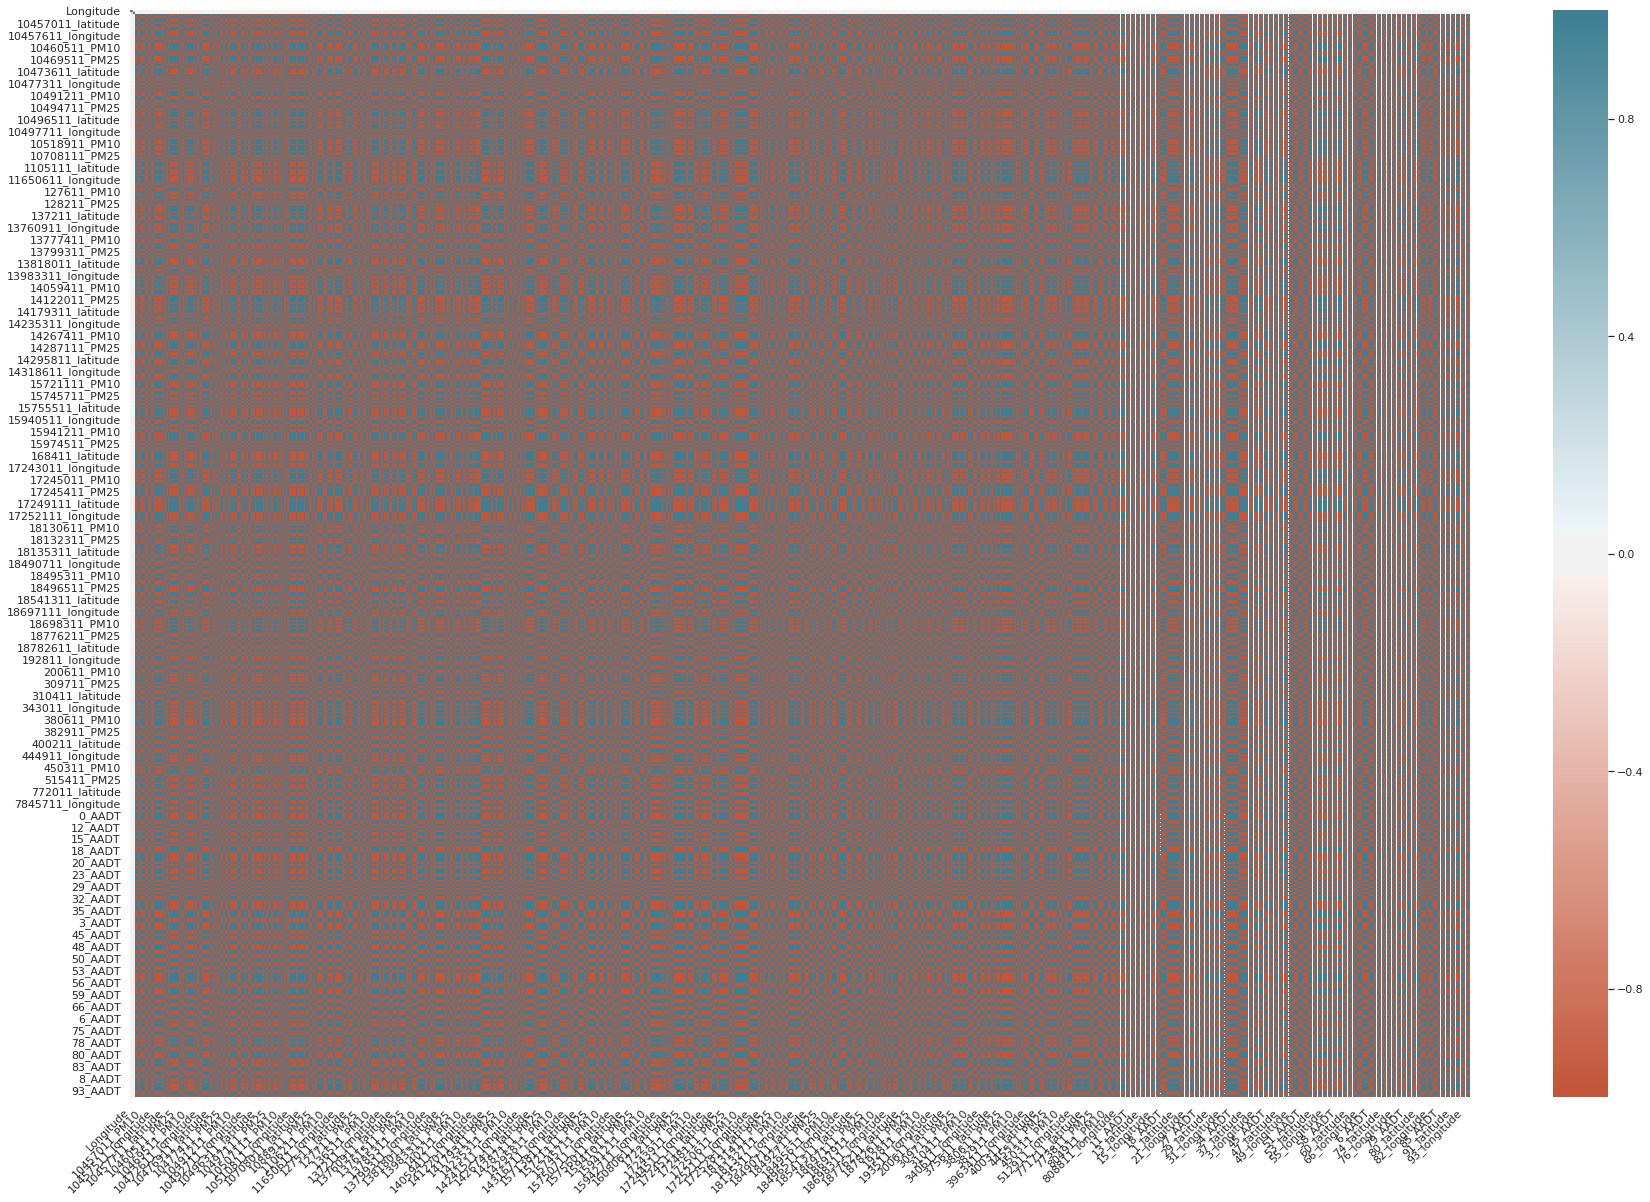

In [98]:
fig, ax = plt.subplots(figsize=(30, 20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=500),
    square=False
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()